In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/aditijain/opt/anaconda3/lib/python3.7/site-packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
from sklearn import datasets

In [6]:
n=25000
n=4*(n//4)

In [7]:
mu11=5
mu12=12
mu1=[mu11,mu12]
sig11=50
sig12=70
cov1=[[sig11,0],[0,sig12]]
x1 = np.random.multivariate_normal(mu1,cov1,n//4)

mu21=60
mu22=100
mu2=[mu21,mu22]
sig21=30
sig22=15
cov2=[[sig21,0],[0,sig22]]
x2 = np.random.multivariate_normal(mu2,cov2,n//4)

mu31=-30
mu32=50
mu3=[mu31,mu32]
sig31=50
sig32=45
cov3=[[sig31,0],[0,sig32]]
x3 = np.random.multivariate_normal(mu3,cov3,n//4)

mu41=70
mu42=-50
mu4=[mu41,mu42]
sig41=45
sig42=75
cov4=[[sig41,0],[0,sig42]]
x4 = np.random.multivariate_normal(mu4,cov4,n//4)

mu51=-90
mu52=-20
mu5=[mu51,mu52]
sig51=30
sig52=60
cov5=[[sig51,0],[0,sig52]]
x5 = np.random.multivariate_normal(mu5,cov5,n//4)


In [8]:
x_n = np.concatenate((x1,x2,x5))
np.random.shuffle(x_n)

In [9]:
X=np.concatenate((x_n,x3,x4))
X = StandardScaler().fit_transform(X)

In [10]:

x_train = X[6250:]
x_test=X[:6250]
y_test=np.zeros(int((n//4)))

y_train = np.concatenate((np.zeros(int(n//2)),np.ones(int(n//4)),np.ones(n//4))).reshape(-1, 1).astype(int)
print(x_train)
print(y_train)

[[ 0.03461902 -0.07791735]
 [-1.60989738 -0.68278207]
 [-0.16241535 -0.26105142]
 ...
 [ 1.15873349 -1.3931458 ]
 [ 1.06238621 -1.01852709]
 [ 0.89158089 -1.54840033]]
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


In [11]:
print(x1.shape)
print(X.shape)

(6250, 2)
(31250, 2)


In [33]:
fpr_values_kraska = []
size_values_kraska = []

# Kraska Hash Model

In [13]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [14]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32

        m = int(model_size/10) + 1
        net_size = model_size + m

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_test,y_test)

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

Number of nodes: 1


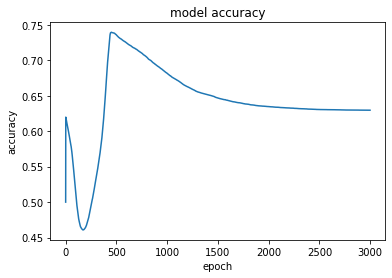

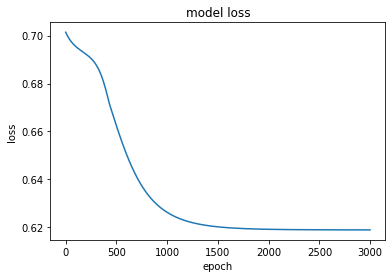

Size: 177.000000 bits - FPR: 0.643520 



Number of nodes: 2


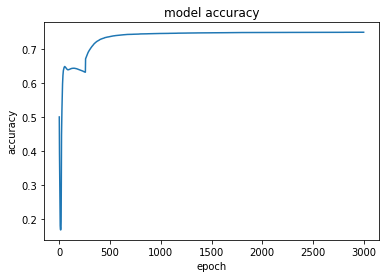

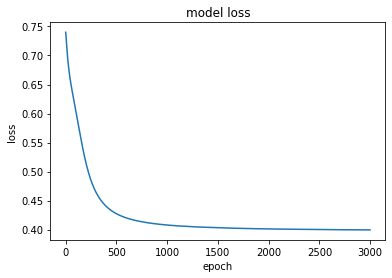

Size: 317.000000 bits - FPR: 0.666560 



Number of nodes: 3


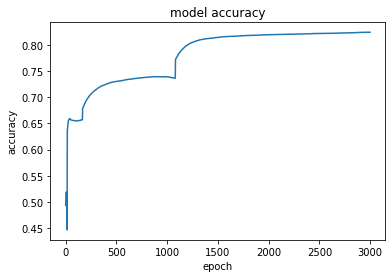

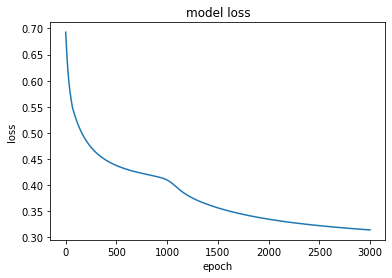

Size: 458.000000 bits - FPR: 0.478080 



Number of nodes: 4


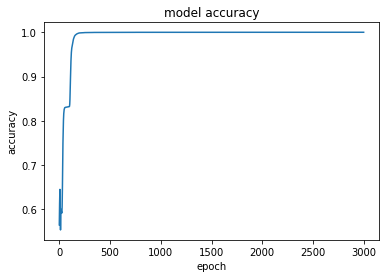

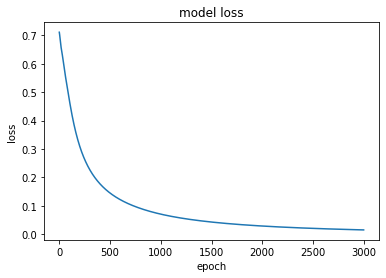

Size: 599.000000 bits - FPR: 0.000000 



Number of nodes: 5


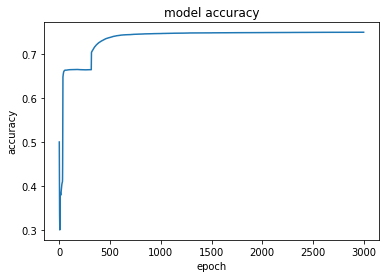

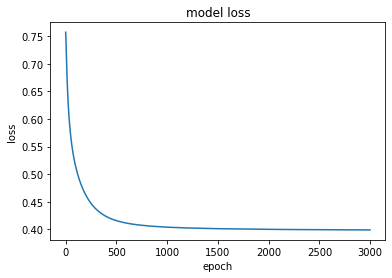

Size: 740.000000 bits - FPR: 0.665760 





In [34]:
get_data_points_Kraska(x_train,y_train,x_test,y_test,1,1,5,3000,fpr_values_kraska,size_values_kraska)

In [27]:
fpr_values_kraska2 = []
size_values_kraska2 = []
fpr_values_kraska1 = []
size_values_kraska1 = []

Number of nodes: 1


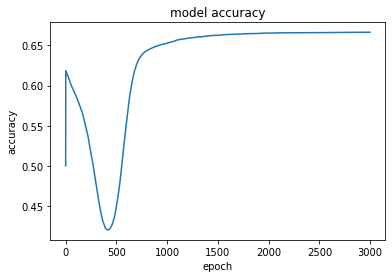

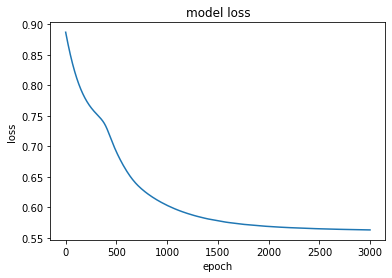

Size: 177.000000 bits - FPR: 0.668800 



Number of nodes: 2


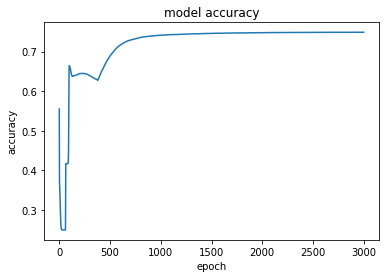

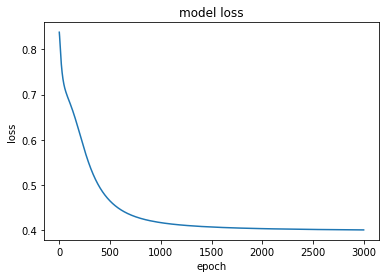

Size: 317.000000 bits - FPR: 0.665280 



Number of nodes: 3


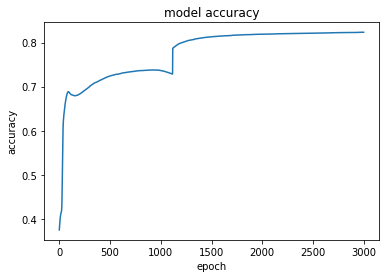

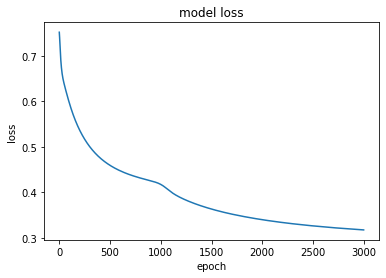

Size: 458.000000 bits - FPR: 0.494720 



Number of nodes: 4


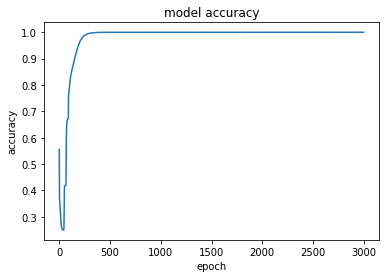

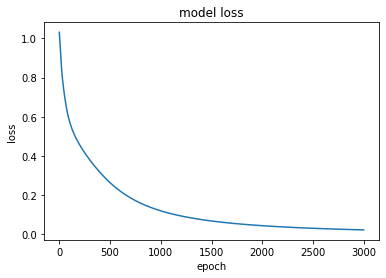

Size: 599.000000 bits - FPR: 0.000000 



Number of nodes: 5


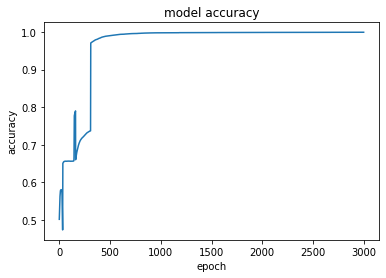

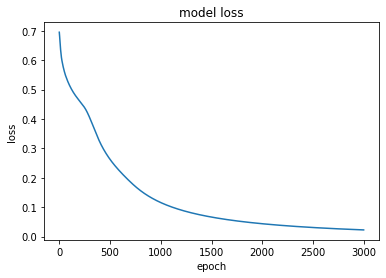

Size: 740.000000 bits - FPR: 0.000640 





In [28]:
get_data_points_Kraska(x_train,y_train,x_test,y_test,1,1,5,3000,fpr_values_kraska1,size_values_kraska1)

Number of nodes: 1


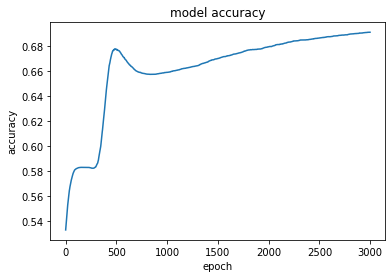

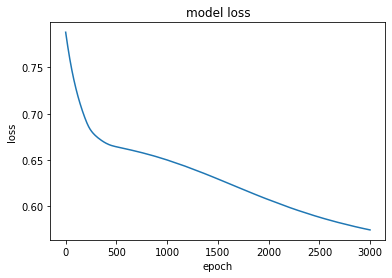

Size: 177.000000 bits - FPR: 1.000000 



Number of nodes: 2


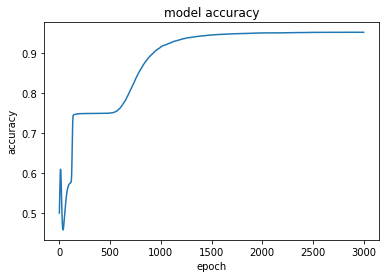

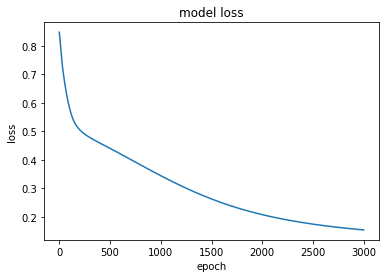

Size: 317.000000 bits - FPR: 1.000000 



Number of nodes: 3


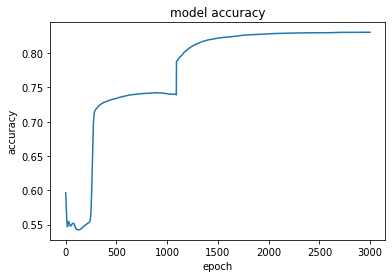

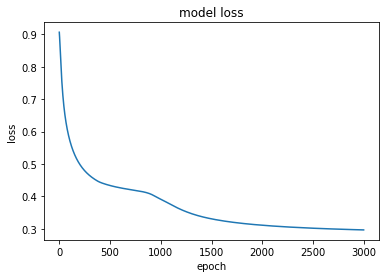

Size: 458.000000 bits - FPR: 0.346880 



Number of nodes: 4


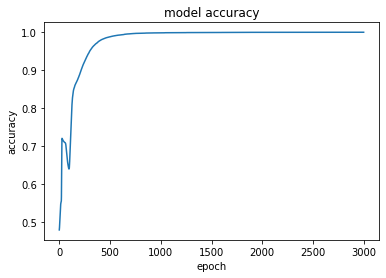

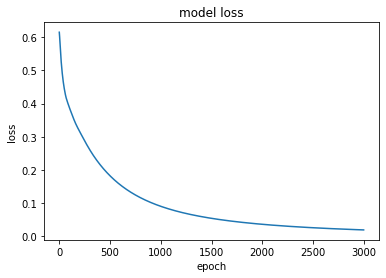

Size: 599.000000 bits - FPR: 0.001120 



Number of nodes: 5


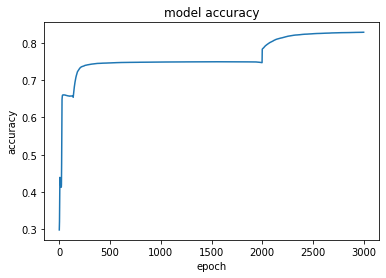

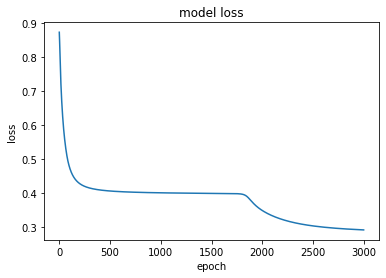

Size: 740.000000 bits - FPR: 0.331360 





In [29]:
get_data_points_Kraska(x_train,y_train,x_test,y_test,1,1,5,3000,fpr_values_kraska2,size_values_kraska2)

In [48]:
fpr_kraska=np.array(fpr_values_kraska)
fpr_kraska.reshape(-1,1)
fpr_kraska_=np.concatenate((np.array(fpr_values_kraska1).reshape(-1,1),np.array(fpr_values_kraska2).reshape(-1,1)))
fpr_kraska_=np.array(fpr_kraska_)

In [52]:
fpr_kraska.reshape(1,-1)

array([[0.64352, 0.66656, 0.47808, 0.     , 0.66576]])

In [53]:
fpr_kraska.shape

(5,)

In [30]:
print(size_values_kraska)

[177, 317, 458, 599, 740, 881, 1021, 1162, 1303, 177, 317, 458, 599, 740]


In [31]:
print(fpr_values_kraska1)

[0.6688, 0.66528, 0.49472, 0.0, 0.00064]


In [32]:
print(size_values_kraska1)

[177, 317, 458, 599, 740]


In [40]:
print(fpr_values_kraska2)

[1.0, 1.0, 0.34688, 0.00112, 0.33136]


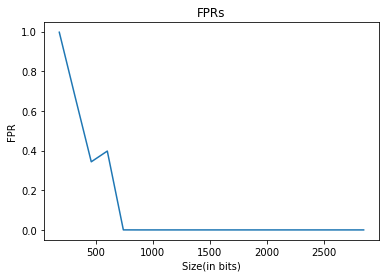

In [16]:
plt.plot(size_values_kraska,fpr_values_kraska)
plt.title('FPRs')
plt.xlabel('Size(in bits)')
plt.ylabel('FPR')
plt.show()

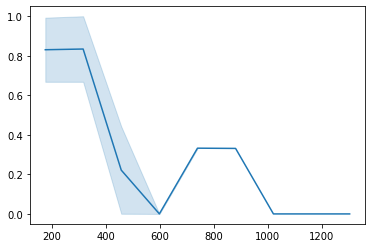

In [23]:
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band")

# Projection model

In [19]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [18]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [20]:
fpr_values = []
size_values = []

In [20]:
n = sum(y_train)
diff = n[0]//50
num = 200

In [21]:
get_data_points_Projection(x_train,x_test,y_train,5,diff,num,100,fpr_values,size_values)

(12500, 2)
Size: 5 Bits - FPR: 0.328800 



Size: 255 Bits - FPR: 0.002880 



Size: 505 Bits - FPR: 0.002240 



Size: 755 Bits - FPR: 0.002240 



Size: 1005 Bits - FPR: 0.001280 



Size: 1255 Bits - FPR: 0.001440 



Size: 1505 Bits - FPR: 0.001120 



Size: 1755 Bits - FPR: 0.000960 



Size: 2005 Bits - FPR: 0.000640 



Size: 2255 Bits - FPR: 0.001120 



Size: 2505 Bits - FPR: 0.000960 



Size: 2755 Bits - FPR: 0.001120 



Size: 3005 Bits - FPR: 0.000960 



Size: 3255 Bits - FPR: 0.000640 



Size: 3505 Bits - FPR: 0.000960 



Size: 3755 Bits - FPR: 0.001120 



Size: 4005 Bits - FPR: 0.000160 



Size: 4255 Bits - FPR: 0.000480 



Size: 4505 Bits - FPR: 0.000640 



Size: 4755 Bits - FPR: 0.000320 



Size: 5005 Bits - FPR: 0.000480 



Size: 5255 Bits - FPR: 0.000640 



Size: 5505 Bits - FPR: 0.000160 



Size: 5755 Bits - FPR: 0.000000 



Size: 6005 Bits - FPR: 0.000480 



Size: 6255 Bits - FPR: 0.000800 



Size: 6505 Bits - FPR: 0.000320 



Size: 6755 Bits - FPR: 

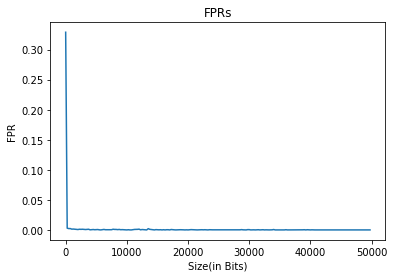

In [22]:
plt.plot(size_values,fpr_values)
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()

# Normal Bloom Filter Values

In [23]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [24]:
print(sum(y_train))
print(len(y_train))

[12500]
25000


In [25]:
n = sum(y_train)
y_ideal = [ideal_fpr(x,n) for x in size_values]

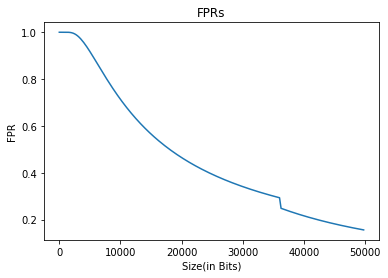

In [26]:
plt.plot(size_values,y_ideal)
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter

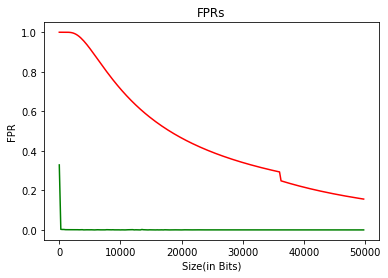

In [27]:
plt.plot(size_values,y_ideal,color='red')
plt.plot(size_values,fpr_values,color='green')
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()
# Red- Normal Bloom Filter
# Green- Projection Model

#  FPR Comparison between Kraska Hash Model, Projection Model and Normal Bloom Filter

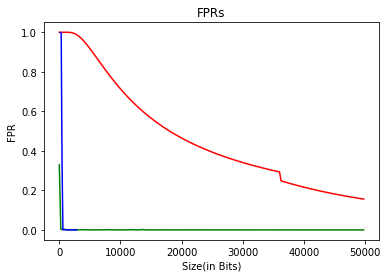

In [28]:
plt.plot(size_values,y_ideal,color='red')
plt.plot(size_values,fpr_values,color='green')
plt.plot(size_values_kraska,fpr_values_kraska,color='blue')
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()
# Red- Normal Bloom Filter
# Green- Projection Model
# Blue- Kraska Hash Model

# Size comparisons

In [21]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]


In [22]:
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values,size_values_kraska)

(12500, 2)
Size: 177 Bits - FPR: 0.008160 



Size: 317 Bits - FPR: 0.003360 



Size: 458 Bits - FPR: 0.002240 



Size: 599 Bits - FPR: 0.003520 



Size: 740 Bits - FPR: 0.001280 



Size: 881 Bits - FPR: 0.001440 



Size: 1021 Bits - FPR: 0.001120 



Size: 1162 Bits - FPR: 0.002240 



Size: 1303 Bits - FPR: 0.001280 



Size: 1444 Bits - FPR: 0.000960 



Size: 1585 Bits - FPR: 0.001920 



Size: 1725 Bits - FPR: 0.001280 



Size: 1866 Bits - FPR: 0.000960 



Size: 2007 Bits - FPR: 0.001280 



Size: 2148 Bits - FPR: 0.000480 



Size: 2289 Bits - FPR: 0.000640 



Size: 2429 Bits - FPR: 0.000640 



Size: 2570 Bits - FPR: 0.000640 



Size: 2711 Bits - FPR: 0.000480 



Size: 2852 Bits - FPR: 0.000800 





In [24]:
n = sum(y_train)
y_ideal = [ideal_fpr(x,n) for x in size_values_kraska]

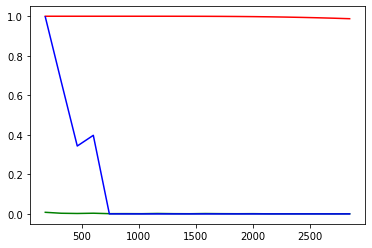

In [31]:
plt.plot(size_values_kraska,y_ideal,color='red')
plt.plot(size_values_kraska,fpr_values,color='green')
plt.plot(size_values_kraska,fpr_values_kraska,color='blue')

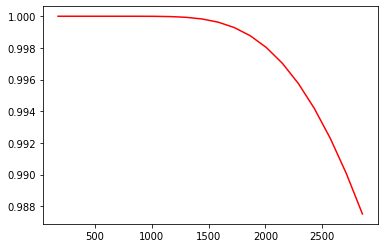

In [30]:
plt.plot(size_values_kraska,y_ideal,color='red')
plt.plot(size_values_kraska,fpr_values,color='green')
